In [1]:
import librosa
import librosa.display
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy import signal
from tqdm.notebook import tqdm
from glob import glob
import gc

import tensorflow as tf
import keras
from keras import layers, losses
from keras.models import Model, load_model
import keras.backend as K

from keras.losses import binary_crossentropy, mean_squared_error

from keras.layers import Input,Conv2D, Layer, UpSampling2D, MaxPooling2D, Dense, Flatten, Lambda, GlobalAveragePooling2D, Conv2DTranspose, Reshape, BatchNormalization, Dropout, ELU, ReLU
from tensorflow.keras.utils import plot_model
import pdb

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
train_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')[:-100]
test_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')[-100:]

BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
min_level_db = -80 

In [3]:
def data_loader(path):
    path = bytes.decode(path.numpy())
    spec = tf.cast(np.load(path),tf.float32)
    spec = tf.expand_dims(spec,axis=-1)
    return spec

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db


In [4]:
def get_dataset(data_paths):
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    dataset = dataset.map(lambda x : tf.py_function(data_loader, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x : tf.py_function(normalize, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [5]:
X_train = get_dataset(train_paths)
X_test = get_dataset(test_paths)

### Creating the model

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        
        ## Creating Encoder
        encoder_inputs = keras.Input(shape=(128, 431, 1))
        x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
        s1,s2 = x.shape[1],x.shape[2]
        x = layers.Flatten()(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        
        
        ## Creating Decoder
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(s1 * s2 * 32, activation="relu")(latent_inputs)
        x = layers.Reshape((s1, s2, 32))(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder_outputs = layers.Resizing(128, 431)(decoder_outputs)
        self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.square((data-reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self,inputs):
        x = inputs
        z_mean, z_log_var, z = self.encoder(x)
        x = self.decoder(z)
        
        return x


In [7]:
model = VAE(10240)
model.build((None, 128, 431, 1))
model._set_inputs(tf.ones((1, 128, 431, 1)))

In [34]:
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VAE/model.{epoch:02d}-{loss:.2f}',monitor='reconstruction_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VAE/tfboard_logs'),
]

In [35]:
# iter_test = next(iter(X_train))
# model.train_step(iter_test)

In [38]:
model.compile(optimizer='adam')
history = model.fit(X_train, epochs=30, callbacks=model_callbacks,
          steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),
                   verbose=1)

Epoch 1/30
389/389 [==============================] - 101s 255ms/step - loss: 10.5623 - reconstruction_loss: 0.2234 - kl_loss: 2.1112
Epoch 2/30
389/389 [==============================] - 101s 259ms/step - loss: 0.2046 - reconstruction_loss: 0.2015 - kl_loss: 0.0034
Epoch 3/30
190/389 [=============>................] - ETA: 48s - loss: 0.2007 - reconstruction_loss: 0.1992 - kl_loss: 0.0019

KeyboardInterrupt: 

### Rough Test

In [28]:
import librosa
import librosa.display
import IPython.display as ipd

sr = 22050
hop_length = 512
n_fft = 1024

song_info = pd.read_csv('D:/Projects/Orpheus_ai/DataSet/main_dataframe.csv')

In [29]:
test_dataset = next(iter(X_train))[0]
model_output = model.predict(test_dataset)

2/2 [==============================] - 1s 7ms/step


In [30]:
index = 15

## Original
S = test_dataset.numpy()[index,:,:,0]
S = denormalize(S)

## Original
S_hat = model_output[index,:,:,0]
S_hat = denormalize(S_hat)

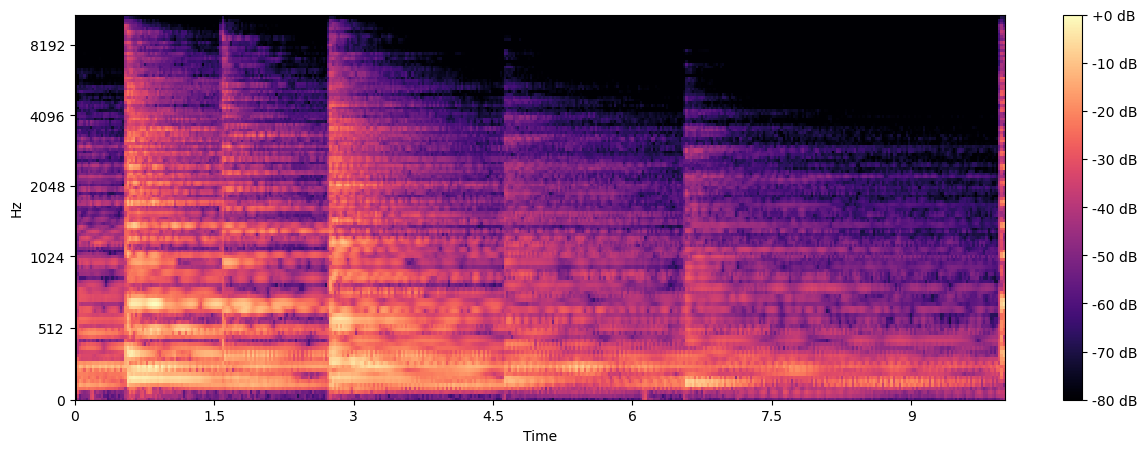

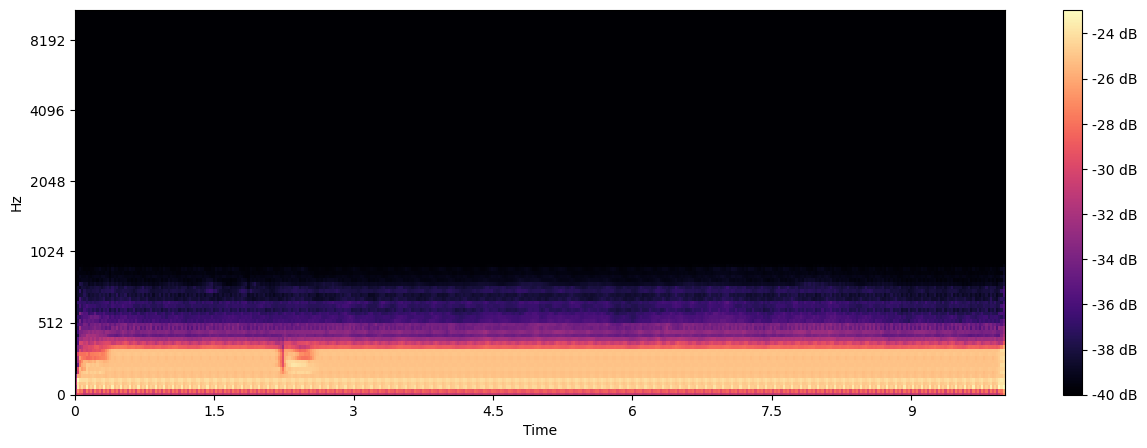

In [31]:
## Original
plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Recreated
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_hat, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [42]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)

In [43]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S_hat),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)